In [1]:
# !gsutil cp -r gs://volume_ai_1yr_daily_data/* /home/jupyter/lstm/

In [ ]:
# !pip install captum

## Install Package

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from plotnine import *
from plotnine.data import *
import random
from sklearn.utils import resample
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ExponentialLR, OneCycleLR
from captum.attr import IntegratedGradients
from plotnine.data import *
import seaborn as sns
import gc

## Import Training Data

In [5]:
X_30d_minmaxscaler = np.load('/home/jupyter/lstm/training_array/X_30d_minmaxscaler_feaonly_first4mon_202401_03.npy')
y_30d_minmaxscaler = np.load('/home/jupyter/lstm/training_array/y_30d_minmaxscaler_feaonly_first4mon_202401_03.npy')

In [28]:
user_df_minmaxscaler = np.load('/home/jupyter/lstm/training_array/static_array_first4mon_202401_03.npy')

### Split Train-Test data

In [6]:
X_train_all, X_test, y_train_all, y_test, fea_train_all, fea_test = train_test_split(X_30d_minmaxscaler, y_30d_minmaxscaler, user_array, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val, fea_train, fea_val = train_test_split(X_train_all, y_train_all, fea_train_all, test_size=0.1, random_state=42)

In [7]:
y_train.sum()/len(y_train)

0.8392102252946735

In [8]:
y_test.sum()/len(y_test)

0.8376152537821144

In [9]:
y_val.sum()/len(y_val)

0.8379950771984784

In [13]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float().unsqueeze(-1)
fea_train = torch.from_numpy(fea_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float().unsqueeze(-1)
fea_test = torch.from_numpy(fea_test).float()
X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float().unsqueeze(-1)
fea_val = torch.from_numpy(fea_val).float()

## Performance Evaluation Function

In [15]:
def evaluate_model(model, X_test, y_test, fea_test):
    model.eval()
    with torch.no_grad():
        y_test_list = []
        y_pred_list = [] 
        for seq, labels, feature in zip(X_test, y_test, fea_test):
            seq, labels, feature = seq.to(device).float(), labels.to(device).float(), feature.to(device).float()
            y_pred = model(seq.unsqueeze(0), feature.unsqueeze(0))
            y_pred = (y_pred > 0.5).float()
            
            y_test_list.append(labels.squeeze().tolist())
            y_pred_list.append(y_pred.squeeze().tolist())
    
    
    target_names = ['Non-Active', 'Active']
    print(classification_report(y_test_list, y_pred_list, target_names=target_names))

## GRU Model, Add Static feature layer

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
batch_size = 32

dataset_train = TensorDataset(X_train, y_train, fea_train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = TensorDataset(X_val, y_val, fea_val)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

In [ ]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, feature_dim, num_layers=2):
        super(GRUModel, self).__init__()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.extracter = nn.Linear(input_dim, input_dim)
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.mid_fc = nn.Linear(hidden_dim, hidden_dim)
        # self.fc = nn.Linear(hidden_dim, output_dim)
        self.fc = nn.Linear(hidden_dim + feature_dim, output_dim)
    
    def forward(self, x, important_features):
        # x: (batch_size, seq_len, input_dim)
        x = self.dropout(self.relu(self.extracter(x)))
        output, hidden = self.gru(x)
        mid_output = self.dropout(self.relu(self.mid_fc(output[:, -1, :])))
        concat_input = torch.cat((mid_output, important_features), dim=1)  # (batch_size, hidden_dim + feature_dim)
        output = torch.sigmoid(self.fc(concat_input))
        return output

In [ ]:
model = GRUModel(input_dim=X_train.shape[2], hidden_dim=128, output_dim=y_train.shape[1], feature_dim=fea_train.shape[1]).to(device) # input_dim, hidden_dim, output_dim

# Loss function & Optimizer
loss_function = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001, weight_decay=0.01) # , weight_decay=0.01

# Learning rate scheduler
epochs = 100
total_steps = len(dataloader_train) * epochs
scheduler = OneCycleLR(optimizer, max_lr=0.0001, total_steps=total_steps, epochs=epochs)

In [ ]:
def train_model(model, optimizer, dataloader_train, dataloader_val, scheduler, epochs):
    
    # patience = 20
    best_val_loss = float('inf')
    # counter = 0
    # epoch = 0

    train_losses = []
    val_losses = []
    
    for epoch in tqdm.tqdm(range(epochs)):
        model.train()
        epoch += 1
        for batch in dataloader_train:
            seqs, labels, features = batch
            seqs, labels, features = seqs.to(device).float(), labels.to(device).float(), features.to(device).float(),
            optimizer.zero_grad()

            y_pred = model(seqs, features)
            loss = loss_function(y_pred, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
        
        train_losses.append(loss.item())
        
        
        model.eval()
        with torch.no_grad():
            for batch in dataloader_val:
                seqs, labels, features = batch
                seqs, labels, features = seqs.to(device).float(), labels.to(device).float(), features.to(device).float(),
                val_pred = model(seqs, features)
                val_pred = val_pred
                labels = labels
                val_loss = loss_function(val_pred, labels)
            val_losses.append(val_loss.item())
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch:3}, Train Loss: {loss.item():10.8f}, Val Loss: {val_loss.item():10.8f}')
            current_lr = scheduler.get_last_lr()[0]
            print(f'Epoch {epoch:3}, Loss: {loss.item()}, Learning Rate: {current_lr}')


                
        # best model weight
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'/home/jupyter/lstm/model/gru_best_model_weightdecay001_staticfea_first4mon.pt')
    
    
    plt.plot(list(range(1, epochs+1, 1)), val_losses)
    plt.plot(list(range(1, epochs+1, 1)), train_losses)
    plt.xlabel('Model Complexity')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss vs. Model Complexity')
    plt.show()

### Static Data Concat

#### Final Model

 10%|█         | 10/100 [00:38<05:47,  3.86s/it]

Epoch  10, Train Loss: 0.17129144, Val Loss: 0.33350199
Epoch  10, Loss: 0.17129144072532654, Learning Rate: 2.800115440700391e-05


 20%|██        | 20/100 [01:17<05:07,  3.85s/it]

Epoch  20, Train Loss: 0.29069829, Val Loss: 0.29834172
Epoch  20, Loss: 0.2906982898712158, Learning Rate: 7.60023087584805e-05


 30%|███       | 30/100 [01:55<04:28,  3.83s/it]

Epoch  30, Train Loss: 0.29749402, Val Loss: 0.12137920
Epoch  30, Loss: 0.2974940240383148, Learning Rate: 9.999999996813078e-05


 40%|████      | 40/100 [02:34<03:49,  3.82s/it]

Epoch  40, Train Loss: 0.25750342, Val Loss: 0.27815869
Epoch  40, Loss: 0.2575034201145172, Learning Rate: 9.504768860705023e-05


 50%|█████     | 50/100 [03:12<03:11,  3.83s/it]

Epoch  50, Train Loss: 0.21424437, Val Loss: 0.24807462
Epoch  50, Loss: 0.21424436569213867, Learning Rate: 8.117316965615154e-05


 60%|██████    | 60/100 [03:50<02:32,  3.82s/it]

Epoch  60, Train Loss: 0.17890437, Val Loss: 0.18598947
Epoch  60, Loss: 0.17890436947345734, Learning Rate: 6.112446175346842e-05


 70%|███████   | 70/100 [04:28<01:54,  3.80s/it]

Epoch  70, Train Loss: 0.27366138, Val Loss: 0.27417797
Epoch  70, Loss: 0.27366137504577637, Learning Rate: 3.88724573803937e-05


 80%|████████  | 80/100 [05:07<01:17,  3.87s/it]

Epoch  80, Train Loss: 0.32966918, Val Loss: 0.26438719
Epoch  80, Loss: 0.32966917753219604, Learning Rate: 1.8824438905939206e-05


 90%|█████████ | 90/100 [05:45<00:38,  3.83s/it]

Epoch  90, Train Loss: 0.35073099, Val Loss: 0.10550983
Epoch  90, Loss: 0.3507309854030609, Learning Rate: 4.951162261781821e-06


100%|██████████| 100/100 [06:24<00:00,  3.84s/it]

Epoch 100, Train Loss: 0.19502337, Val Loss: 0.14021774
Epoch 100, Loss: 0.19502337276935577, Learning Rate: 4.000318692185736e-10


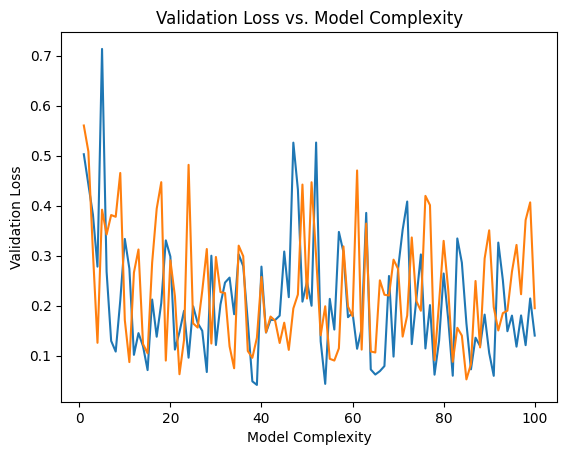

In [ ]:
# Min-max Scaler (Final Version)
train_model(model, optimizer, dataloader_train, dataloader_val, scheduler, epochs)

In [ ]:
best_model_path = '/home/jupyter/lstm/model/gru_best_model_weightdecay001_staticfea3.pt'
best_model = GRUModel(input_dim=X_train.shape[2], hidden_dim=128, output_dim=y_train.shape[1], feature_dim=fea_train.shape[1]).to(device)
best_model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [ ]:
evaluate_model(model, X_test, y_test, fea_test)

              precision    recall  f1-score   support

  Non-Active       0.77      0.72      0.74      2080
      Active       0.94      0.95      0.94      9091

    accuracy                           0.91     11171
   macro avg       0.85      0.84      0.84     11171
weighted avg       0.91      0.91      0.91     11171



In [ ]:
evaluate_model(best_model, X_train, y_train, fea_train)

              precision    recall  f1-score   support

  Non-Active       0.79      0.73      0.76      7503
      Active       0.94      0.96      0.95     32711

    accuracy                           0.91     40214
   macro avg       0.87      0.84      0.85     40214
weighted avg       0.91      0.91      0.91     40214



In [ ]:
evaluate_model(best_model, X_val, y_val, fea_val)

              precision    recall  f1-score   support

  Non-Active       0.79      0.71      0.75       842
      Active       0.93      0.96      0.94      3627

    accuracy                           0.91      4469
   macro avg       0.86      0.83      0.85      4469
weighted avg       0.91      0.91      0.91      4469



In [ ]:
## Final Model
# Min-max Scaler
best_model.eval()
with torch.no_grad():
    y_test_list = []
    y_pred_list = [] 
    for seq, labels, feature in zip(X_test, y_test, fea_test):
        seq, labels, feature = seq.to(device).float(), labels.to(device).float(), feature.to(device).float()
        y_pred = best_model(seq.unsqueeze(0), feature.unsqueeze(0))
        y_pred = (y_pred > 0.45).float()

        y_test_list.append(labels.squeeze().tolist())
        y_pred_list.append(y_pred.squeeze().tolist())


target_names = ['Non-Active', 'Active']
print(classification_report(y_test_list, y_pred_list, target_names=target_names))

              precision    recall  f1-score   support

  Non-Active       0.80      0.68      0.73      2080
      Active       0.93      0.96      0.94      9091

    accuracy                           0.91     11171
   macro avg       0.86      0.82      0.84     11171
weighted avg       0.90      0.91      0.90     11171

